# Import libraries 

In [10]:
import pandas as pd
import numpy as np
import seaborn as sns

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, accuracy_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.ensemble import RandomForestClassifier
import statistics as stats

In [12]:
import math

# Import data

In [ ]:
data = pd.read_csv('../../raw_data/bitstampUSD.csv')

In [163]:
data

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
2798176,2017-05-01 00:00:00,1348.88,1354.80,1348.88,1354.80,3.087374,4173.722673,1351.868203
2798177,2017-05-01 00:01:00,1352.41,1352.41,1352.41,1352.41,0.261954,354.269412,1352.410000
2798178,2017-05-01 00:02:00,1349.49,1354.86,1349.49,1354.86,0.096311,130.384815,1353.783259
2798179,2017-05-01 00:03:00,1350.11,1351.25,1350.11,1351.25,0.260284,351.553973,1350.655803
2798180,2017-05-01 00:04:00,1351.25,1351.25,1349.52,1349.52,1.089116,1470.056120,1349.769693
...,...,...,...,...,...,...,...,...
4727771,2020-12-30 23:55:00,28809.07,28825.50,28800.01,28810.08,0.087391,2517.799582,28810.597267
4727772,2020-12-30 23:56:00,28801.47,28829.42,28785.64,28829.42,0.965221,27804.572129,28806.429798
4727773,2020-12-30 23:57:00,28829.42,28863.90,28829.42,28857.06,2.368831,68332.350629,28846.441863
4727774,2020-12-30 23:58:00,28850.49,28900.52,28850.49,28882.82,2.466590,71232.784464,28879.056266


# Nan's exploration

<AxesSubplot:>

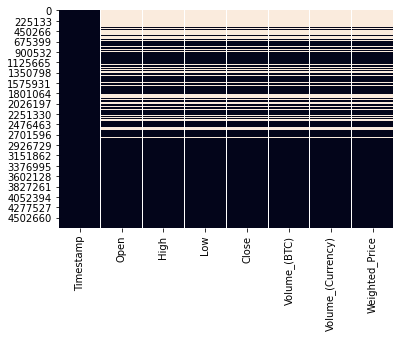

In [5]:
sns.heatmap(data.isnull(), cbar=False)

To be continued !

# Preprocessing, input data, Model, Cross Val

In [1]:
def get_data():
    """method to get the training data (or a portion of it) from google cloud bucket"""
    # client = storage.Client()
    # data = pd.read_csv(f"gs://{BUCKET_NAME}/{BUCKET_TRAIN_DATA_PATH}")
    data = pd.read_csv('../../raw_data/bitstampUSD.csv')
    # data = pd.read_csv('gs://bitcoin-prediction-01/data/bitstampUSD.csv')
    data = data[2798176:4727776].copy()
    return data


In [2]:
def select_date(data, date_start, date_end):
    
    if date_start != None:
        if date_end != None:
            data = data[date_start:date_end].copy()
    else:
        data = data.copy()
        
    return data

In [3]:
# select_data(data, "2020-8-1", "2020-10-2") 

In [4]:
def preprocessing_data(data, features_size, h):
        
    data_pp = data.copy()
    data_pp['diff_Open'] = data_pp['Open'].diff(h)
    data_pp['diff_Open'] = data_pp['diff_Open'].dropna()
    data_pp[f"t+{h}"] = data_pp['diff_Open'].shift(-h)
    
    for i in range(0, features_size):
        data_pp[f't-{i}'] = data_pp['Open'].shift(i)
    data_shifted = data_pp.dropna()
    
    return data_shifted

In [5]:
# preprocessing_data(data, 50, 2)

In [6]:
def features_target(data_shifted, h):
    
    X = data_shifted.drop(columns=['Open', 'diff_Open', f"t+{h}"])
    y = data_shifted[f"t+{h}"].copy()
    y[y > 0] = 1
    y[y <= 0] = 0
    
    data_size = data_shifted.shape[0]
    
    return X, y, data_size

In [7]:
def input_data(X, y, sample_size, train_fraction, features_size, data_size, train_size, test_size, h=1, w=0):    
 

    sample_X = X.iloc[data_size-(test_size * w + sample_size) : data_size - (test_size * w)]
    sample_y = y.iloc[data_size-(test_size * w + sample_size) : data_size - (test_size * w)]
    
    X_train = sample_X.iloc[0:train_size]
    y_train = sample_y.iloc[0:train_size]
    X_test = sample_X.iloc[(train_size+h-1):(sample_size)]
    y_test = sample_y.iloc[(train_size+h-1):(sample_size)]
    
    return X_train, X_test, y_train, y_test

In [37]:
def predict_score(model_init, X_train, X_test, y_train, y_test):
    model = model_init
    model = model.fit(X_train, y_train)
    results = model.predict(X_test)
    score = model.score(X_test, y_test) 
    
    return score

In [27]:
def cross_val(model_init=RidgeClassifier(), sample_size=1000, train_fraction=0.7, features_size=60, h=1, date_start=None, date_end=None):
    
    data = get_data()
    data = select_date(data, date_start, date_end)
    data_shifted = preprocessing_data(data, features_size, h)
    X, y, data_size = features_target(data_shifted, h)
    train_size = int(train_fraction*sample_size)
    test_size = sample_size - train_size
    
    
    r = math.floor((data_size-train_size)/test_size)
    intervals = range(0, r)
    reversed_intervals = reversed(intervals)
    results = []
    
    for i in reversed_intervals:
        X_train, X_test, y_train, y_test = input_data(X, y, sample_size, train_fraction, features_size, data_size, train_size, test_size, h, w=i)
        score = predict_score(model_init, X_train, X_test, y_train, y_test)
        results.append(score)
        
    return dict({'mean_score':round(stats.mean(results),2), 'std':round(stats.stdev(results),2) , 'score_min':round(min(results),2), 'score_max':round(max(results),2)})
    

In [26]:
cross_val(model_init=RidgeClassifier(), sample_size=1000, train_fraction=0.7, features_size=60, h=1, date_start=None, date_end=None)

{'mean_score': 0.7427853999482268,
 'std': 0.05,
 'score_min': 0.47333333333333333,
 'score_max': 0.9}

In [28]:
cross_val(model_init=RidgeClassifier(), sample_size=1000, train_fraction=0.7, features_size=60, h=1, date_start=None, date_end=None)

{'mean_score': 0.74, 'std': 0.05, 'score_min': 0.47, 'score_max': 0.9}

In [29]:
cross_val(model_init=RidgeClassifier(), sample_size=1000, train_fraction=0.7, features_size=60, h=30, date_start=None, date_end=None)

{'mean_score': 0.52, 'std': 0.1, 'score_min': 0.18, 'score_max': 0.86}

In [30]:
cross_val(model_init=RidgeClassifier(), sample_size=1440, train_fraction=0.7, features_size=60, h=10, date_start=None, date_end=None)

{'mean_score': 0.55, 'std': 0.05, 'score_min': 0.33, 'score_max': 0.7}

In [31]:
cross_val(model_init=RidgeClassifier(), sample_size=1440, train_fraction=0.7, features_size=60, h=5, date_start=None, date_end=None)

{'mean_score': 0.59, 'std': 0.04, 'score_min': 0.41, 'score_max': 0.7}

In [32]:
cross_val(model_init=RidgeClassifier(), sample_size=1440, train_fraction=0.7, features_size=60, h=2, date_start=None, date_end=None)

{'mean_score': 0.67, 'std': 0.04, 'score_min': 0.47, 'score_max': 0.78}

In [159]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

In [ ]:
model = Sequential()
model.add(layers.SimpleRNN(units=1, activation='tanh')) # we'll look at units number later
model.add(layers.Dense(1, activation="relu"))

# The compilation
model.compile(loss='mse', 
              optimizer='rmsprop')

# The fit
model.fit(X, y,
         batch_size=16,
         epochs=10, verbose=0)

# The prediction
model.predict(X)

In [ ]:
model = Sequential()
model.add(LSTM(10, activation='tanh'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, batch_size=64)

In [ ]:
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)

In [35]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
import numpy
 
# Function to create model, required for KerasClassifier
def create_model():
 # create model
    model = Sequential()
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
     # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

# create model
modeldeep = KerasClassifier(build_fn=create_model)

In [40]:
modeldeep

In [39]:
cross_val(model_init=modeldeep, sample_size=1440, train_fraction=0.7, features_size=60, h=2, date_start=None, date_end=None)

32/32 [==============================] - 0s 2ms/step - loss: 16058873.3030 - accuracy: 0.4721


AttributeError: 'History' object has no attribute 'evaluate'

In [ ]:
# create model
modeldeep_2 = KerasClassifier(build_fn=create_model)